# Forecasting with LSTM Neural Network - Multistep

Single-pass LSTM Neural Networks:
- Process a single element of the sequence at a time.
- Predict the next element of the sequence based on the current element and the internal state of the network.
- Do not take into account the broader context of the sequence.
- Commonly used for tasks such as sequence classification or anomaly detection.

Multistep LSTM Neural Networks:
- Process multiple elements of the sequence at a time.
- Predict the next element of the sequence based on several previous elements and the internal state of the network.
- Can take into account the broader context of the sequence.
- Commonly used for tasks such as machine translation or text generation.

This project focuses on utilizing multistep LSTM neural networks for predictive modeling.

### 01. Import libraries

In [2]:
#pip install torch==2.2.1 torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118

In [2]:
# Set to run in 'GPU'
import torch

print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

# Check for available GPUs
if torch.cuda.is_available():
    device = torch.device('cuda')  # Use the first available GPU
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")

    # Move all tensors to the GPU by default
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    print("No GPU available, using CPU.")
    device = torch.device('cpu')

1
NVIDIA GeForce RTX 3050 Laptop GPU
Using GPU: NVIDIA GeForce RTX 3050 Laptop GPU


In [3]:
# Packages
import numpy as np
import pandas as pd

# Graph
from matplotlib import pyplot as plt
import seaborn as sns

# Tensor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Data source
import yfinance as yf

# Create features (datetime)
from fastai.tabular.core import add_datepart

### 02. Import data

__yfinance__ is a Python library that simplifies access and manipulation of financial data, allowing users to easily interact with historical and current stock market data. Here are the main reasons to use it:

In [4]:
# Download historical data for a stock
df = yf.download(tickers='^GSPC', period='10y', interval='1d')

# Move the index to a column
df = df.reset_index()

# Drop the MultiIndex level (keep the first level only)
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.droplevel(1)

# Replace blank space in the name of the columns
df.columns = df.columns.str.lower().str.replace(' ', '_')

df.head()

[*********************100%***********************]  1 of 1 completed


Price,date,close,high,low,open,volume
0,2014-12-31,2058.899902,2085.580078,2057.939941,2082.110107,2606070000
1,2015-01-02,2058.199951,2072.360107,2046.040039,2058.899902,2708700000
2,2015-01-05,2020.579956,2054.439941,2017.339966,2054.439941,3799120000
3,2015-01-06,2002.609985,2030.250000,1992.439941,2022.150024,4460110000
4,2015-01-07,2025.900024,2029.609985,2005.550049,2005.550049,3805480000


### 03. Feature engineering

In feature engineering, the transformation, creation and selection of the most relevant features from the original data is carried out, with the aim of improving the accuracy and efficiency of the models.

In [5]:
# Sort the DataFrame by the 'date' column in ascending order
df = df.sort_values(by='date', ascending=True)

# Calculate difference close price between days
df['prev_close'] = df.shift(1)['close']
df['close_change'] = df.apply(
    lambda row: 0 if np.isnan(row.prev_close) else (row.close - row.prev_close), 
    axis=1
)

df.drop('prev_close', axis=1, inplace=True)

df.head()

Price,date,close,high,low,open,volume,close_change
0,2014-12-31,2058.899902,2085.580078,2057.939941,2082.110107,2606070000,0.000000
1,2015-01-02,2058.199951,2072.360107,2046.040039,2058.899902,2708700000,-0.699951
2,2015-01-05,2020.579956,2054.439941,2017.339966,2054.439941,3799120000,-37.619995
3,2015-01-06,2002.609985,2030.250000,1992.439941,2022.150024,4460110000,-17.969971
4,2015-01-07,2025.900024,2029.609985,2005.550049,2005.550049,3805480000,23.290039


In [6]:
# Ensure the 'date' column is the index
df = df.set_index('date')

# Make the DataFrame have daily frequency (including weekends)
df = df.asfreq('D')

# Forward fill missing data (weekends will be filled with the previous available data)
df = df.ffill(downcast='infer')

# Sort by date to ensure it's in chronological order
df = df.sort_index()

# Reset the index if you want to move 'date' back to a column
df = df.reset_index()

df.head()

C:\Users\mateo\AppData\Local\Temp\ipykernel_30408\3554955727.py:8: FutureWarning: The 'downcast' keyword in ffill is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  df = df.ffill(downcast='infer')


Price,date,close,high,low,open,volume,close_change
0,2014-12-31,2058.899902,2085.580078,2057.939941,2082.110107,2606070000,0.000000
1,2015-01-01,2058.899902,2085.580078,2057.939941,2082.110107,2606070000,0.000000
2,2015-01-02,2058.199951,2072.360107,2046.040039,2058.899902,2708700000,-0.699951
3,2015-01-03,2058.199951,2072.360107,2046.040039,2058.899902,2708700000,-0.699951
4,2015-01-04,2058.199951,2072.360107,2046.040039,2058.899902,2708700000,-0.699951


In [7]:
# Add date parts
df = add_datepart(df, 'date')
df.drop('Elapsed', axis=1, inplace=True)
df['mon_fri'] = ((df['Dayofweek'] == 0) | (df['Dayofweek'] == 4)).astype(int)

# Replace blank space in the name of the columns
df.columns = df.columns.str.lower().str.replace(' ','_')

# Convert all boolean columns to 1 and 0
boolean_columns = ['is_month_end', 'is_month_start', 'is_quarter_end', 'is_quarter_start', 'is_year_end', 'is_year_start'] 
df[boolean_columns] = df[boolean_columns].astype(int)

df.head()

Price,close,high,low,open,volume,close_change,year,month,week,day,dayofweek,dayofyear,is_month_end,is_month_start,is_quarter_end,is_quarter_start,is_year_end,is_year_start,mon_fri
0,2058.899902,2085.580078,2057.939941,2082.110107,2606070000,0.000000,2014,12,1,31,2,365,1,0,1,0,1,0,0
1,2058.899902,2085.580078,2057.939941,2082.110107,2606070000,0.000000,2015,1,1,1,3,1,0,1,0,1,0,1,0
2,2058.199951,2072.360107,2046.040039,2058.899902,2708700000,-0.699951,2015,1,1,2,4,2,0,0,0,0,0,0,1
3,2058.199951,2072.360107,2046.040039,2058.899902,2708700000,-0.699951,2015,1,1,3,5,3,0,0,0,0,0,0,0
4,2058.199951,2072.360107,2046.040039,2058.899902,2708700000,-0.699951,2015,1,1,4,6,4,0,0,0,0,0,0,0


In [8]:
# clase as first column from pre-procesing
column_to_move = 'close'
columns = [column_to_move] + [col for col in df.columns if col != column_to_move]
df = df[columns]

df.head()

Price,close,high,low,open,volume,close_change,year,month,week,day,dayofweek,dayofyear,is_month_end,is_month_start,is_quarter_end,is_quarter_start,is_year_end,is_year_start,mon_fri
0,2058.899902,2085.580078,2057.939941,2082.110107,2606070000,0.000000,2014,12,1,31,2,365,1,0,1,0,1,0,0
1,2058.899902,2085.580078,2057.939941,2082.110107,2606070000,0.000000,2015,1,1,1,3,1,0,1,0,1,0,1,0
2,2058.199951,2072.360107,2046.040039,2058.899902,2708700000,-0.699951,2015,1,1,2,4,2,0,0,0,0,0,0,1
3,2058.199951,2072.360107,2046.040039,2058.899902,2708700000,-0.699951,2015,1,1,3,5,3,0,0,0,0,0,0,0
4,2058.199951,2072.360107,2046.040039,2058.899902,2708700000,-0.699951,2015,1,1,4,6,4,0,0,0,0,0,0,0


### 04. Pre-processing

Unlike other machine learning models, in the case of time series, __it is crucial to ensure that partitions are performed respecting the temporal order of the data__, avoiding random mixing of the data.

In [9]:
# Function to generate partitions preserving the characteristics of the time series
def train_val_test_split(dataframe, tr_size=0.8, vl_size=0.1, ts_size=0.1):
    N = dataframe.shape[0]
    Ntrain = int(tr_size*N)
    Nval = int(vl_size*N)
    Ntst = N - Ntrain - Nval

    train = dataframe[0:Ntrain]
    val = dataframe[Ntrain:Ntrain+Nval]
    test = dataframe[Ntrain+Nval:]

    return train, val, test

# Apply function
df_tr, df_vl, df_ts = train_val_test_split(df)

print(f'Train Set Size: {df_tr.shape}')
print(f'Validation Set Size: {df_vl.shape}')
print(f'Test Set Size: {df_ts.shape}')

Train Set Size: (2922, 19)
Validation Set Size: (365, 19)
Test Set Size: (366, 19)


So in this case each training data will be:

- An arrangement of 30 (days) x 19 (features) corresponding to the entry
- An arrangement of 7 (days) x 1 (feature):

In this case, `input_length` (30 days) and `output_length` (7 days) will become hyperparameters that should later be tuned to improve model performance.

In [10]:
# Function to create the dataset
def create_dataset(array, input_length, output_length):
    '''Creates a dataset with inputs (X) and outputs (Y) required by the LSTM Network.

    Parameters:
    - array: numpy array of size N x features (N: number of data points, f: number of features)
    - input_length: consecutive time steps from the time series to feed into the model
    - output_length: time steps to predict (model output)
    '''
    # Initialization
    X, Y = [], []
    shape = array.shape

    if len(shape) == 1: # Univariate
        fils, cols = array.shape[0], 1
        array = array.reshape(fils, cols)
    else: # Multivariate
        fils, cols = array.shape

    # Generate the arrays | The 0 in Y is the column expected to be the response variable
    for i in range(fils - input_length - output_length):
        X.append(array[i:i + input_length, 0:cols])
        Y.append(array[i + input_length:i + input_length + output_length, 0].reshape(output_length,1))

    # Convert lists to NumPy arrays
    X = np.array(X)
    Y = np.array(Y)

    return X, Y

# Create training, validation, and test datasets and check their sizes
input_length = 30    # Hyperparameter
output_length = 7    # Multi-step model

df_tr_x, df_tr_y = create_dataset(df_tr.values, input_length, output_length)
df_vl_x, df_vl_y = create_dataset(df_vl.values, input_length, output_length)
df_ts_x, df_ts_y = create_dataset(df_ts.values, input_length, output_length)

print('Sizes of input (BATCHES x INPUT_LENGTH x FEATURES) and output (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Training set - df_tr_x: {df_tr_x.shape}, df_tr_y: {df_tr_y.shape}')
print(f'Validation set - df_vl_x: {df_vl_x.shape}, df_vl_y: {df_vl_y.shape}')
print(f'Test set - df_ts_x: {df_ts_x.shape}, df_ts_y: {df_ts_y.shape}')

Sizes of input (BATCHES x INPUT_LENGTH x FEATURES) and output (BATCHES x OUTPUT_LENGTH x FEATURES)
Training set - df_tr_x: (2885, 30, 19), df_tr_y: (2885, 7, 1)
Validation set - df_vl_x: (328, 30, 19), df_vl_y: (328, 7, 1)
Test set - df_ts_x: (329, 30, 19), df_ts_y: (329, 7, 1)


__It is better to scale the data separately for the training, validation, and test sets, rather than scaling the entire DataFrame from the beginning.__ This prevents the test and validation data from influencing the model's training, which better simulates a real-world scenario where the model does not have access to future information.

In [11]:
from sklearn.preprocessing import MinMaxScaler

def scale_dataset(data_input, col_ref):
    '''Scales the dataset within the range of -1 to 1.

    Parameters:
    - data_input: dictionary containing the input and output datasets of the model
                    (e.g., {'df_tr_x': df_tr_x, 'df_tr_y': df_tr_y, 'df_vl_x': df_vl_x, 'df_vl_y': df_vl_y, 
                            'df_ts_x': df_ts_x, 'df_ts_y': df_ts_y})
    - col_ref: additional parameter to specify the column containing the target variable

    Returns:
    - data_scaled: dictionary with scaled input and output datasets
    (same structure as the input dictionary)
    - scaler: the scaler used (required for making predictions)
    '''

    # *** Additional implementation: determine the index of the column
    # containing the target variable
    col_ref_idx = df.columns.get_loc(col_ref)

    # Number of time steps in the input and covariate features
    nsamples = data_input['df_tr_x'].shape[1]
    nfeats = data_input['df_tr_x'].shape[2]

    # Generate a list of scalers (one for each input feature)
    scalers = [MinMaxScaler(feature_range=(-1, 1)) for _ in range(nfeats)]

    # Arrays to hold the scaled datasets
    df_tr_x_s = np.zeros(data_input['df_tr_x'].shape)
    df_vl_x_s = np.zeros(data_input['df_vl_x'].shape)
    df_ts_x_s = np.zeros(data_input['df_ts_x'].shape)
    df_tr_y_s = np.zeros(data_input['df_tr_y'].shape)
    df_vl_y_s = np.zeros(data_input['df_vl_y'].shape)
    df_ts_y_s = np.zeros(data_input['df_ts_y'].shape)

    # Scaling: use min/max values from the training set to scale all datasets

    # Scale X datasets
    for i in range(nfeats):
        df_tr_x_s[:, :, i] = scalers[i].fit_transform(data_input['df_tr_x'][:, :, i])
        df_vl_x_s[:, :, i] = scalers[i].transform(data_input['df_vl_x'][:, :, i])
        df_ts_x_s[:, :, i] = scalers[i].transform(data_input['df_ts_x'][:, :, i])

    # Scale Y datasets (considering "col_ref_idx")
    df_tr_y_s[:, :, 0] = scalers[col_ref_idx].fit_transform(data_input['df_tr_y'][:, :, 0])
    df_vl_y_s[:, :, 0] = scalers[col_ref_idx].transform(data_input['df_vl_y'][:, :, 0])
    df_ts_y_s[:, :, 0] = scalers[col_ref_idx].transform(data_input['df_ts_y'][:, :, 0])

    # Form the output dictionary
    data_scaled = {
        'df_tr_x_s': df_tr_x_s, 'df_tr_y_s': df_tr_y_s,
        'df_vl_x_s': df_vl_x_s, 'df_vl_y_s': df_vl_y_s,
        'df_ts_x_s': df_ts_x_s, 'df_ts_y_s': df_ts_y_s,
    }

    return data_scaled, scalers[col_ref_idx]

In [12]:
# Scaling the dataset using the previous function
# Create input dictionary
data_in = {
    'df_tr_x': df_tr_x, 'df_tr_y': df_tr_y,
    'df_vl_x': df_vl_x, 'df_vl_y': df_vl_y,
    'df_ts_x': df_ts_x, 'df_ts_y': df_ts_y,
}

# Scale the data (specifying the column with the target variable)
data_s, scaler_result = scale_dataset(data_in, col_ref='close')

# Extract scaled subsets
df_tr_x_s, df_tr_y_s = data_s['df_tr_x_s'], data_s['df_tr_y_s']
df_vl_x_s, df_vl_y_s = data_s['df_vl_x_s'], data_s['df_vl_y_s']
df_ts_x_s, df_ts_y_s = data_s['df_ts_x_s'], data_s['df_ts_y_s']

# Print information
print('Input sizes (BATCHES x INPUT_LENGTH x FEATURES) and output sizes (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Scaled training set - df_tr_x_s: {df_tr_x_s.shape}, df_tr_y_s: {df_tr_y_s.shape}')
print(f'Scaled validation set - df_vl_x_s: {df_vl_x_s.shape}, df_vl_y_s: {df_vl_y_s.shape}')
print(f'Scaled test set - df_ts_x_s: {df_ts_x_s.shape}, df_ts_y_s: {df_ts_y_s.shape}')

Input sizes (BATCHES x INPUT_LENGTH x FEATURES) and output sizes (BATCHES x OUTPUT_LENGTH x FEATURES)
Scaled training set - df_tr_x_s: (2885, 30, 19), df_tr_y_s: (2885, 7, 1)
Scaled validation set - df_vl_x_s: (328, 30, 19), df_vl_y_s: (328, 7, 1)
Scaled test set - df_ts_x_s: (329, 30, 19), df_ts_y_s: (329, 7, 1)


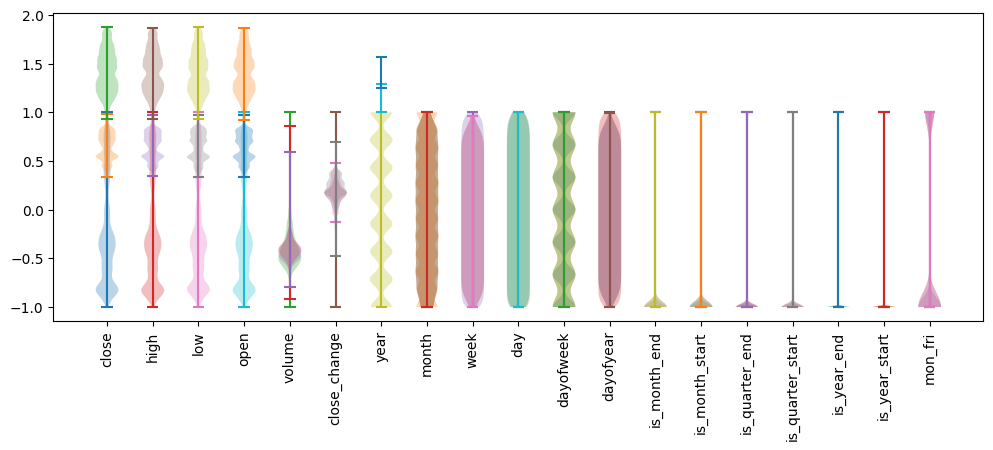

In [13]:
# Generate a violin plot to visualize the distribution
# of values for each covariate (input) and the target variable (output)
fig, ax = plt.subplots(figsize=(12, 4))
for i in range(df.shape[1]):
    ax.violinplot(dataset=df_tr_x_s[:, :, i].flatten(), positions=[i])
    ax.violinplot(dataset=df_vl_x_s[:, :, i].flatten(), positions=[i])
    ax.violinplot(dataset=df_ts_x_s[:, :, i].flatten(), positions=[i])

# Set horizontal axis labels
ax.set_xticks(list(range(df.shape[1])))
ax.set_xticklabels(df.keys(), rotation=90)
ax.autoscale()

[Text(1, 0, 'y (output)')]

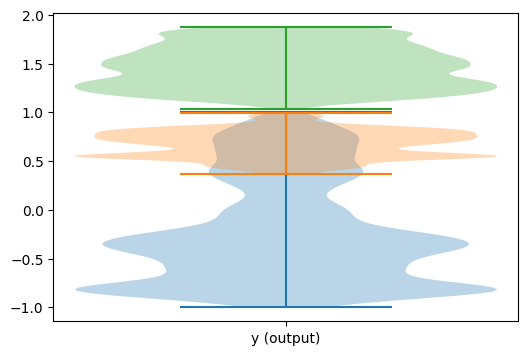

In [14]:
# Let's do the same for the target variable:
fig, ax = plt.subplots(figsize=(6, 4))
ax.violinplot(dataset=df_tr_y_s.flatten())
ax.violinplot(dataset=df_vl_y_s.flatten())
ax.violinplot(dataset=df_ts_y_s.flatten())
ax.set_xticks([1])
ax.set_xticklabels(['y (output)'])

### 05. Modeling

An LSTM (Long Short-Term Memory) model is a type of recurrent neural network (RNN) designed to work with sequences of data. Its structure allows it to capture long-term dependencies and address issues such as the vanishing gradient problem. The main components of an LSTM model are:

___1. Memory cells___

The memory cells store important information from the sequences to capture long-term dependencies.
<br><br>

___2. Main gates___

The gates regulate the flow of information in the cell and ensure that only relevant information is retained. They are controlled by activation functions (such as sigmoid and tanh), which include:

- Input gate:
Decides how much new information will be stored in the memory cell.
$i_t = \sigma(W_{xi}x_t + W_{hi}h_{t-1} + b_i)$
Where $i_t$ is the vector that decides what information should enter the cell.

- Forget gate:
Decides what information in the memory cell should be discarded.
$f_t = \sigma(W_{xf}x_t + W_{hf}h_{t-1} + b_f)$
Here, $f_t$ regulates which part of $C_{t-1}$ should be forgotten.

- Output gate:
Controls what part of the information from the memory cell should be sent to the next hidden state.
$o_t = \sigma(W_{xo}x_t + W_{ho}h_{t-1} + b_o)$
<br><br>

___3. Network States___
- Cell state:
Represents long-term memory. It is updated with the combination of the input, output, and forget gates.
$C_t = f_t \odot C_{t-1} + i_t \odot \tilde{C}_t$
Where $tilde{C}_t = \text{tanh}(W_{xc}x_t + W_{hc}h_{t-1} + b_c)$ is the new candidate content.

- Hidden state:
Represents short-term memory. It is passed to the next layer or the next time step.
$h_t = o_t \odot \text{tanh}(C_t)$
<br><br>

___4. Activation Functions___
- Linear:
It is simply an identity function, meaning the output is equal to the input.
Common usage: Regression networks.

- Sigmoid:
Used in the gates to limit values between 0 and 1, especially useful in situations where probabilities or proportions need to be modeled.
Common usage: Gates in LSTM or binary classification.

- Tanh:
Used to generate the cell updates and outputs, restricting values between -1 and 1.
Common usage: Memory cells or deep neural networks.

- ReLU (Rectified Linear Unit):
Any negative value is set to zero, while positive values remain unchanged.
Common usage: Deep neural networks.

- Leaky ReLU:
Similar to ReLU, but with a small negative slope instead of zero when negative values exist.
Common usage: Deep neural networks.
<br><br>

___5. Pesos y sesgos___
- Weights  ($W$):
Determine the influence of the current input ($x_t$) and the previous hidden state ($h_{t-1}$) on each gate.

- Biases ($b$):
Allow the adjustment of each gate's calculations to improve learning.
<br><br>

__Summary of Data Flow in LSTM:__
1. The input ($x_t$) and the previous hidden state ($h_{t-1}$) are processed through the gates.
2. The cell state ($C_t$) is updated by combining retained, forgotten, and new information.
3. The new hidden state ($h_t$) is computed, which is used for the output and as input for the next step.

In [15]:
# Model creation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
import tensorflow as tf

# Set parameters for reproducibility
tf.random.set_seed(123)
tf.config.experimental.enable_op_determinism()

# Model Definition
n_units = 128  # Size of the hidden state (h) and memory cell (c)
input_shape = (df_tr_x_s.shape[1], df_tr_x_s.shape[2])

# Building the Model
model = Sequential()
model.add(LSTM(n_units, input_shape=input_shape))
model.add(Dropout(0.2))
model.add(Dense(output_length, activation='linear'))  # 'linear' activation for regression tasks

# Loss function: RMSE (Root Mean Squared Error)
# RMSE keeps errors in the same units as the target variable
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred - y_true)))
    return rmse

# Model compilation
optimizer = RMSprop(learning_rate=5e-4)  # RMSprop, Adam
model.compile(
    optimizer=optimizer,
    loss=root_mean_squared_error,
)

# Model trainig
epochs = 80  # Hyperparameter
batch_size = 256  # Hyperparameter
history = model.fit(
    x=df_tr_x_s,
    y=df_tr_y_s,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(df_vl_x_s, df_vl_y_s),
    verbose=2
)

c:\Users\mateo\Videos\git\lstm-stock-prediction\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/80
12/12 - 3s - 239ms/step - loss: 0.2751 - val_loss: 0.0854
Epoch 2/80
12/12 - 2s - 183ms/step - loss: 0.1390 - val_loss: 0.0748
Epoch 3/80
12/12 - 1s - 85ms/step - loss: 0.1267 - val_loss: 0.0694
Epoch 4/80
12/12 - 1s - 91ms/step - loss: 0.1167 - val_loss: 0.0683
Epoch 5/80
12/12 - 1s - 88ms/step - loss: 0.1080 - val_loss: 0.0701
Epoch 6/80
12/12 - 1s - 99ms/step - loss: 0.1047 - val_loss: 0.0741
Epoch 7/80
12/12 - 1s - 95ms/step - loss: 0.0982 - val_loss: 0.0607
Epoch 8/80
12/12 - 1s - 79ms/step - loss: 0.0952 - val_loss: 0.0550
Epoch 9/80
12/12 - 1s - 94ms/step - loss: 0.0942 - val_loss: 0.0559
Epoch 10/80
12/12 - 1s - 89ms/step - loss: 0.0898 - val_loss: 0.0585
Epoch 11/80
12/12 - 1s - 97ms/step - loss: 0.0873 - val_loss: 0.0516
Epoch 12/80
12/12 - 1s - 99ms/step - loss: 0.0847 - val_loss: 0.0538
Epoch 13/80
12/12 - 1s - 97ms/step - loss: 0.0832 - val_loss: 0.0538
Epoch 14/80
12/12 - 1s - 92ms/step - loss: 0.0824 - val_loss: 0.0527
Epoch 15/80
12/12 - 1s - 104ms/step - los

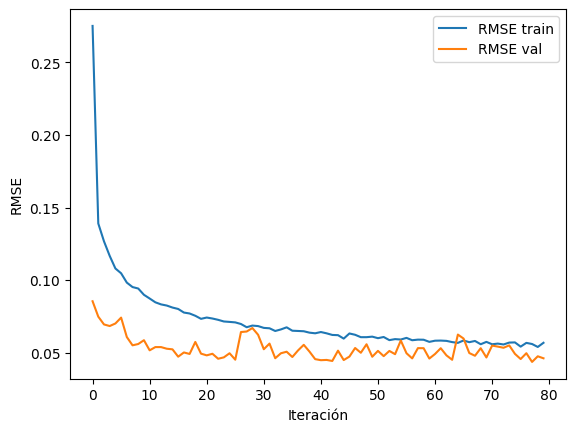

In [16]:
# Plot training and validation curves to verify that there is no overfitting
plt.plot(history.history['loss'],label='RMSE train')
plt.plot(history.history['val_loss'],label='RMSE val')
plt.xlabel('Iteración')
plt.ylabel('RMSE')
plt.legend()

### 06. Model evaluation and interpretation

Assuming the model has already been fine-tuned and trained, we will check its performance on the test set and compare it with the performance obtained on the training and validation sets.

In [17]:
# Calculation of rmses for train, val y test
rmse_tr = model.evaluate(x = df_tr_x_s, y = df_tr_y_s, verbose = 0)
rmse_vl = model.evaluate(x = df_vl_x_s, y = df_vl_y_s, verbose = 0)
rmse_ts = model.evaluate(x = df_ts_x_s, y = df_ts_y_s, verbose = 0)

# Print results on the screen
print('Performance comparison:')
print(f'  RMSE train:\t {rmse_tr:.3f}')
print(f'  RMSE val:\t {rmse_vl:.3f}')
print(f'  RMSE test:\t {rmse_ts:.3f}')

Performance comparison:
  RMSE train:	 0.037
  RMSE val:	 0.045
  RMSE test:	 0.079


The performance on the test set is comparable (though slightly lower) to the training and validation sets, which suggests that the model generalizes well.

However, further model tuning and conducting a feature importance analysis are recommended in order to improve performance.

### 07. Predictions

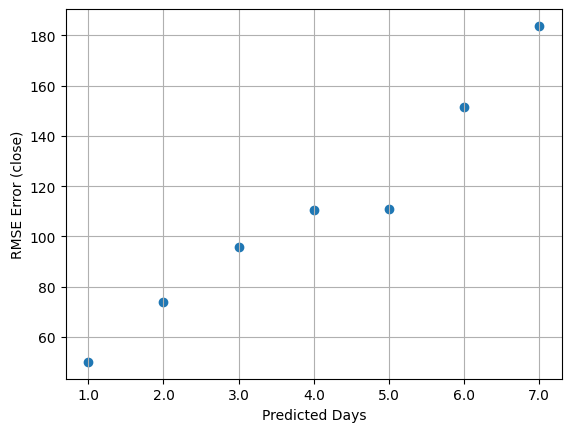

In [ ]:
# 1. Generate predictions on the test set
df_ts_y_pred_s = model.predict(df_ts_x_s, verbose = 0)

# 2. Apply the inverse transformation to the predictions to scale them back to the original scale
df_ts_y_pred = scaler_result.inverse_transform(df_ts_y_pred_s)

# 3. Calculate RMSE for each predicted time step
diff_squared = np.square(df_ts_y.squeeze() - df_ts_y_pred)  # BATCHESx4
means = np.mean(diff_squared, axis = 0)  # 1x4
means_float = means.astype(np.float64)
rmse = np.sqrt(means_float)  # 1x4

# Plot RMSE for each time step
t = np.linspace(1, 7, 7)

fig, ax = plt.subplots()
ax.scatter(t, rmse)
ax.set_xlabel('Predicted Days')
ax.set_ylabel('RMSE Error (close)')
plt.xticks(ticks=t, labels=t)
plt.grid()

In [38]:
df_ts_y_pred[-1]

array([6004.369, 5978.748, 5987.865, 5989.963, 6032.823, 5981.405,
       5975.194], dtype=float32)

Y al igual que ocurría con el modelo univariado-multistep, vemos que en este caso el RMSE se incrementa a medida que nos movemos más hacia adelante en las predicciones.

In [45]:
# Supongamos que el modelo ya está cargado como `model`
# Realiza predicciones
predictions_scaled = model.predict(df_ts_x_s)  # Predicciones escaladas

# scaler_y debe ser el mismo utilizado para escalar df_ts_y_s
predictions = scaler_result.inverse_transform(predictions_scaled)
originals = scaler_result.inverse_transform(df_ts_y_s)

# Reshape para adecuar el formato
predictions = predictions.reshape(-1)
originals = originals.reshape(-1)

# Graficar los resultados
plt.figure(figsize=(12, 6))
plt.plot(originals, label="Original", color="blue")
plt.plot(predictions, label="Predicción", color="orange")
plt.title("Comparación Original vs Predicción")
plt.xlabel("Tiempo")
plt.ylabel("Valores")
plt.legend()
plt.grid(True)
plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


ValueError: Found array with dim 3. None expected <= 2.

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


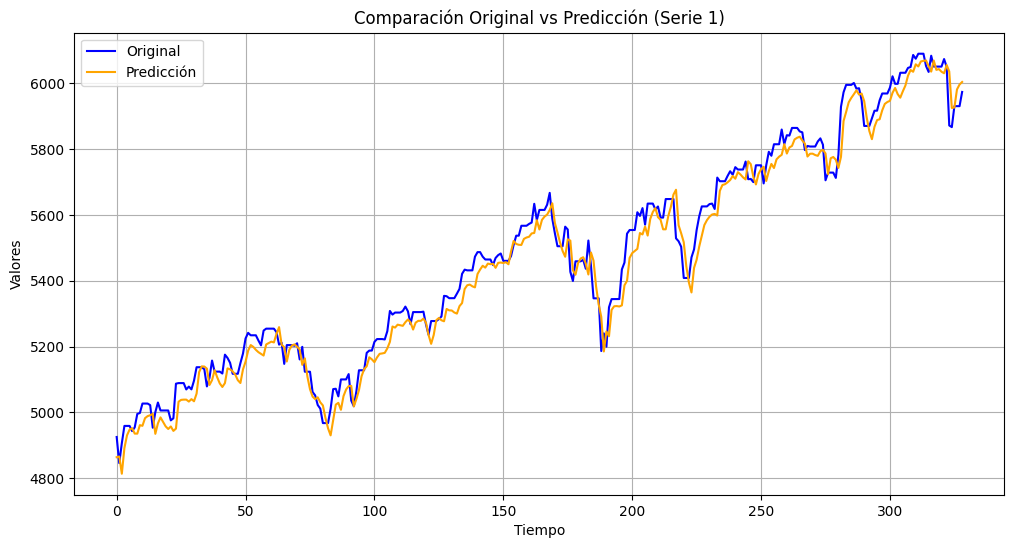

In [55]:
# Realiza predicciones
predictions_scaled = model.predict(df_ts_x_s)  # Dimensión: (329, 7)

# Ajustamos las dimensiones de df_ts_y_s para que sea compatible con scaler_result
df_ts_y_s_reshaped = df_ts_y_s.reshape(df_ts_y_s.shape[0], -1)  # Dimensión: (329, 7)

# Desescalamos los datos
predictions = scaler_result.inverse_transform(predictions_scaled)  # Dimensión: (329, 7)
originals = scaler_result.inverse_transform(df_ts_y_s_reshaped)    # Dimensión: (329, 7)

# Seleccionamos una serie temporal para graficar (por ejemplo, la primera)
index_to_plot = 0  # Cambiar según la serie que se quiera graficar
predictions_to_plot = predictions[:, index_to_plot]  # Dimensión: (329,)
originals_to_plot = originals[:, index_to_plot]      # Dimensión: (329,)

plt.figure(figsize=(12, 6))
plt.plot(originals_to_plot, label="Original", color="blue")
plt.plot(predictions_to_plot, label="Predicción", color="orange")
plt.title(f"Comparación Original vs Predicción (Serie {index_to_plot + 1})")
plt.xlabel("Tiempo")
plt.ylabel("Valores")
plt.legend()
plt.grid(True)
plt.show()

In [47]:
predictions_scaled.shape

(329, 7)

In [52]:
df_ts_x_s.shape

(329, 30, 19)

In [50]:
df_ts_y_s.shape

(329, 7, 1)

In [ ]:
# 1. Generate predictions on the test set
df_ts_y_pred_s = model.predict(df_ts_x_s, verbose = 0)

# 2. Apply the inverse transformation to the predictions to scale them back to the original scale
df_ts_y_pred = scaler_result.inverse_transform(df_ts_y_pred_s)

In [ ]:
df_ts_x_pred

In [ ]:
df_ts_x_pred

In [20]:
def make_predictions(x, model, scaler):
    '''Generates the prediction for OUTPUT_LENGTH future time steps using the trained model.

    Input:
    - x: batch (or batches) of data to input into the model (size: BATCHES X INPUT_LENGTH X FEATURES)
    - model: Trained LSTM network
    - scaler: scaler (required to bring the prediction to the original scale)

    Output:
    - y_pred: the prediction in the original scale (size: BATCHES X OUTPUT_LENGTH X FEATURES)
    '''

    # Compute the scaled prediction in the range of -1 to 1
    y_pred_s = model.predict(x, verbose = 0)

    # Transform the prediction back to the original scale
    y_pred = scaler.inverse_transform(y_pred_s)

    return y_pred.flatten()

In [21]:
# Calcular predicciones sobre el set de prueba
y_ts_pred = make_predictions(df_ts_x_s, model, scaler_result)

In [27]:
y_pred = pd.DataFrame(y_ts_pred)

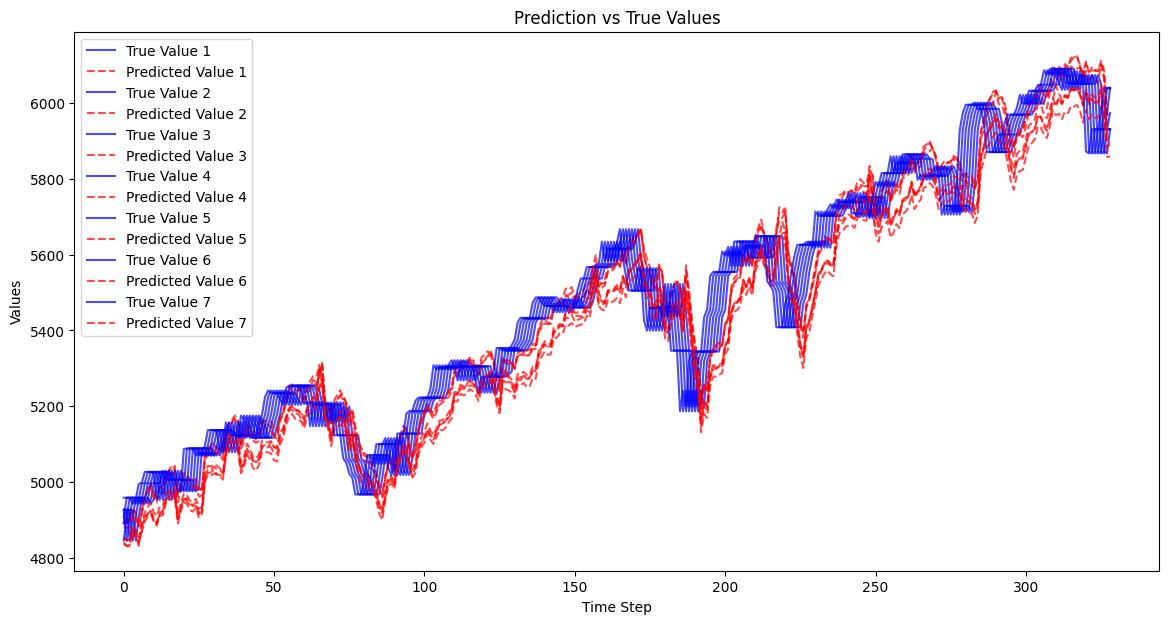

In [136]:
# Reshape y_test_s to match the scaler's expectations
y_test_s_reshaped = df_ts_y_s.reshape(-1, output_length)  # Reshape to (2303, 7)

# Inverse transform the predictions and the true values
y_pred = scaler_result.inverse_transform(y_pred_s)  # Inverse scaling of predictions
y_test = scaler_result.inverse_transform(y_test_s_reshaped)  # Inverse scaling of true values

plt.figure(figsize=(14, 7))
for i in range(output_length):
    plt.plot(y_test[:, i], label=f'True Value {i + 1}', color='blue', alpha=0.7)
    plt.plot(y_pred[:, i], label=f'Predicted Value {i + 1}', color='red', linestyle='--', alpha=0.7)
plt.legend()
plt.title('Prediction vs True Values')
plt.xlabel('Time Step')
plt.ylabel('Values')
plt.show()

Let's analyze this performance graphically by showing the actual stock values and the predictions generated by the model for each data point in the test set:

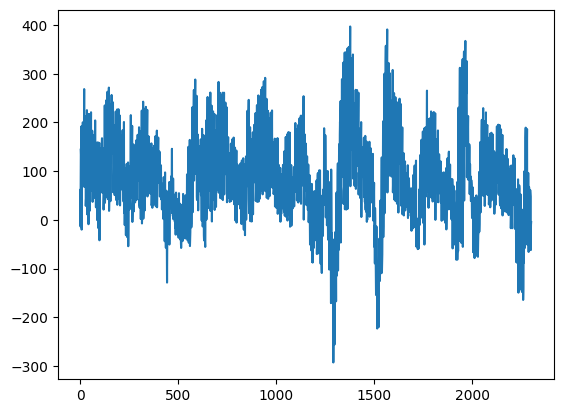

In [25]:
# Get the number of predictions (N) in the test set
N = len(df_ts_y_pred)

# Create an array 'ndato' representing the x-axis for plotting (e.g., time or index)
# np.linspace generates 'N' equally spaced points between 1 and N
ndato = np.linspace(1, N, N)

# Calculate the error by subtracting the predicted values from the true values
# Flatten both arrays to 1D and compute the error for each time step
errors = df_ts_y.flatten() - df_ts_y_pred.flatten()

# Plot the errors to visualize the deviation between true and predicted values
plt.plot(errors)

It is observed that:
- The average error is close to zero.
- However, at certain time points, extreme errors of up to -300 and +300 points are reached.
These errors could be reduced by fine-tuning the model or modifying the prediction approach.

### End